In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression


In [ ]:
# Load data

data = load_wine()
X = data.data          # shape: (n_samples, 13)
y = data.target        # class  in {0, 1, 2}
feature_names = data.feature_names


In [5]:
# Train / Test split  (Step 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,         
    stratify=y,             
    random_state=42
)

# Standardization
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


In [6]:
# Step 1: Simple KNN (k=3) on 13D

knn_3 = KNeighborsClassifier(n_neighbors=3)  
knn_3.fit(X_train_sc, y_train)
y_pred_knn = knn_3.predict(X_test_sc)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Step 1 - KNN (k=3, Euclidean) accuracy: {acc_knn:.3f}")

Step 1 - KNN (k=3, Euclidean) accuracy: 0.944


Step 2 - KNN (k=3) on PCA(2D) accuracy: 0.944


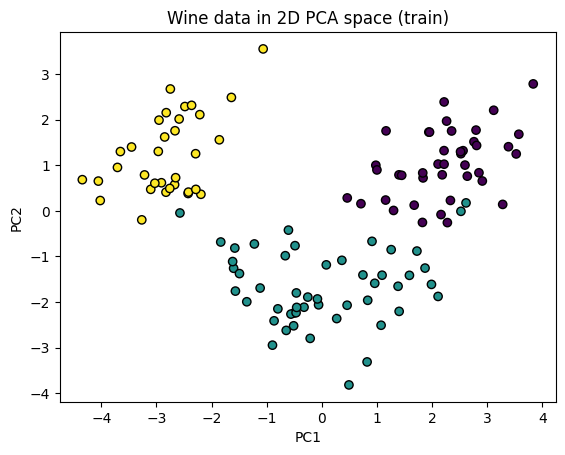

In [ ]:
# Step 2: PCA (13 -> 2) + KNN(3)

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

knn_3_pca = KNeighborsClassifier(n_neighbors=3)
knn_3_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_3_pca.predict(X_test_pca)
acc_knn_pca = accuracy_score(y_test, y_pred_knn_pca)
print(f"Step 2 - KNN (k=3) on PCA(2D) accuracy: {acc_knn_pca:.3f}")

# Visualize PCA scatter
plt.figure()
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wine data in 2D PCA space (train)")
plt.show()


In [9]:

# Step 3: Rule-Based system on Alcohol

# Find index of 'alcohol' feature
alcohol_index = feature_names.index('alcohol')

# Extract Alcohol feature for test set
alcohol_test = X_test[:, alcohol_index]

def rule_based_classifier(alcohol_values):
    preds = []
    for a in alcohol_values:
        if a < 12:
            preds.append(0)
        elif a < 13:
            preds.append(1)
        else:
            preds.append(2)
    return np.array(preds)

y_pred_rule = rule_based_classifier(alcohol_test)
acc_rule = accuracy_score(y_test, y_pred_rule)
print(f"Step 3 - Rule-based (Alcohol thresholds) accuracy: {acc_rule:.3f}")


Step 3 - Rule-based (Alcohol thresholds) accuracy: 0.426


In [11]:
# Step 4: Effect of distance metrics in KNN on 13D

metrics = ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'mahalanobis']
metric_accuracies = {}

for m in metrics:
    if m == 'mahalanobis':
        # compute VI (inverse covariance) on training data
        cov = np.cov(X_train_sc, rowvar=False)
        VI = np.linalg.inv(cov)
        knn = KNeighborsClassifier(
            n_neighbors=3,
            metric='mahalanobis',
            metric_params={'VI': VI}
        )
    else:
        knn = KNeighborsClassifier(
            n_neighbors=3,
            metric=m
        )
    knn.fit(X_train_sc, y_train)
    y_pred_m = knn.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred_m)
    metric_accuracies[m] = acc
    print(f"Step 4 - KNN (k=3, metric={m}) accuracy: {acc:.3f}")

Step 4 - KNN (k=3, metric=euclidean) accuracy: 0.944
Step 4 - KNN (k=3, metric=manhattan) accuracy: 0.963
Step 4 - KNN (k=3, metric=chebyshev) accuracy: 0.907
Step 4 - KNN (k=3, metric=cosine) accuracy: 0.926
Step 4 - KNN (k=3, metric=mahalanobis) accuracy: 0.944


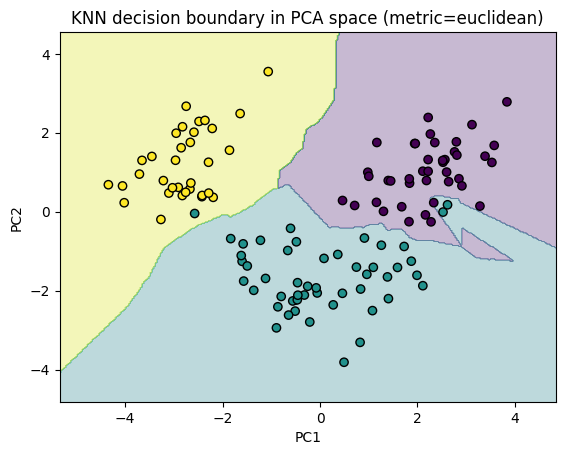

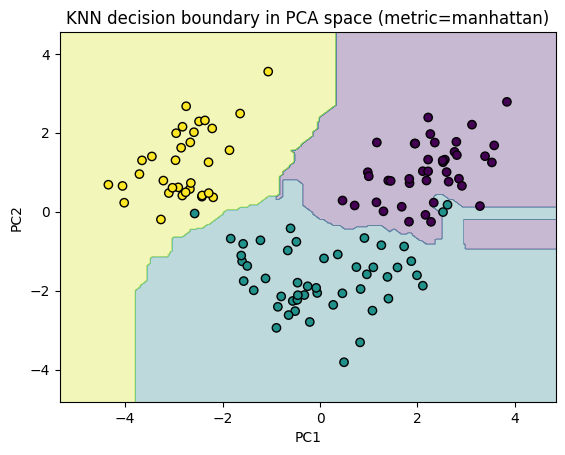

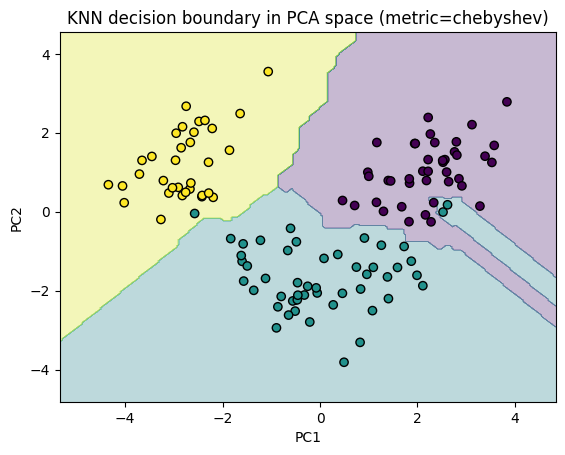

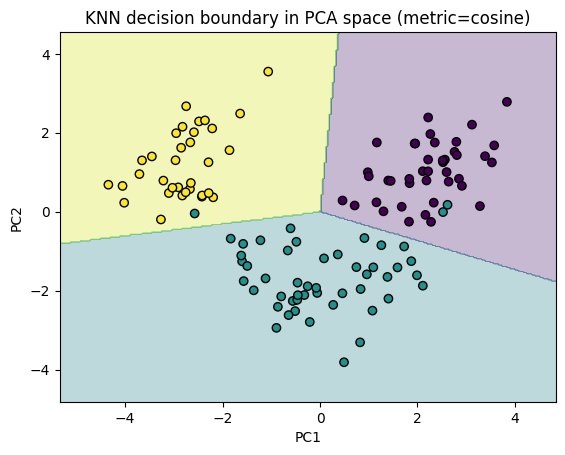

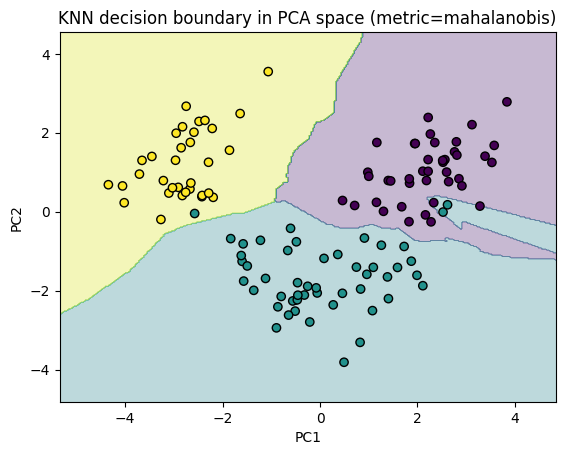

In [ ]:
# Step 4 : Decision boundaries in PCA(2D)
# For visualization ONLY: train KNN on 2D PCA space

def plot_decision_boundary_pca(metric_name):
    # Train KNN on PCA(2D) space with given metric
    if metric_name == 'mahalanobis':
        cov2 = np.cov(X_train_pca, rowvar=False)
        VI2 = np.linalg.inv(cov2)
        knn = KNeighborsClassifier(
            n_neighbors=3,
            metric='mahalanobis',
            metric_params={'VI': VI2}
        )
    else:
        knn = KNeighborsClassifier(
            n_neighbors=3,
            metric=metric_name
        )

    knn.fit(X_train_pca, y_train)

    # Grid in PCA space
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"KNN decision boundary in PCA space (metric={metric_name})")
    plt.show()

for m in metrics:
    plot_decision_boundary_pca(m)

Step 5 - Linear Regression (soft encoding) accuracy: 0.907


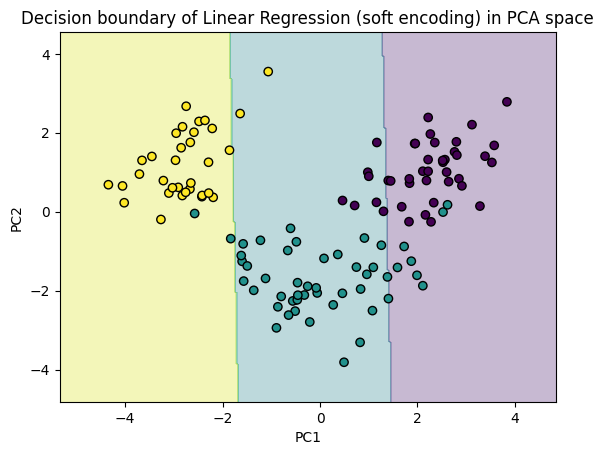

In [13]:
# Step 5: Classification-as-Regression (Soft Encoding)

# Map classes to continuous values
class_to_code = {0: 0.0, 1: 0.5, 2: 1.0}
code_to_class = {0.0: 0, 0.5: 1, 1.0: 2}
codes = np.array([0.0, 0.5, 1.0])

y_train_soft = np.array([class_to_code[c] for c in y_train])

# Train Linear Regression on 13D standardized data
reg = LinearRegression()
reg.fit(X_train_sc, y_train_soft)

# Predict continuous values on test data
y_pred_soft_cont = reg.predict(X_test_sc)

def decode_to_class(y_continuous):
    """Map continuous predictions to nearest of {0.0, 0.5, 1.0}."""
    y_classes = []
    for val in y_continuous:
        idx = np.argmin(np.abs(codes - val))
        # codes[0]=0.0->class0, codes[1]=0.5->class1, codes[2]=1.0->class2
        y_classes.append(int(idx))  # idx directly matches class label
    return np.array(y_classes)

y_pred_soft_cls = decode_to_class(y_pred_soft_cont)
acc_soft = accuracy_score(y_test, y_pred_soft_cls)
print(f"Step 5 - Linear Regression (soft encoding) accuracy: {acc_soft:.3f}")


# Step 5 (continued): Decision boundary for soft regression in PCA(2D)

reg_pca = LinearRegression()
reg_pca.fit(X_train_pca, y_train_soft)

# Create grid in PCA space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict continuous and then map to classes
Z_cont = reg_pca.predict(grid_points)
Z_cls = decode_to_class(Z_cont)
Z_cls = Z_cls.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z_cls, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Decision boundary of Linear Regression (soft encoding) in PCA space")
plt.show()

له، Soft Encoding باعث سوگیری مدل می‌شود. چون با نگاشت کلاس‌ها به مقادیر عددی پیوسته (۰، ۰٫۵، ۱)، به‌صورت ضمنی به مدل القا می‌شود که بین کلاس‌ها ترتیب و فاصله‌ی مساوی وجود دارد؛ در حالی‌که در دیتاست Wine کلاس‌ها اسمی هستند و چنین ترتیبی ندارند. همچنین استفاده از Linear Regression با تابع هزینه‌ی MSE مدل را به سمت پیش‌بینی میانگین خروجی سوق می‌دهد، نه تفکیک واقعی کلاس‌ها.

بله، مدل تمایل دارد کلاس میانی را بیش‌ازحد پیش‌بینی کند. در نواحی هم‌پوشانی کلاس‌ها، مقدار پیش‌بینی‌شده به سمت عدد میانی (۰٫۵) کشیده می‌شود و پس از نگاشت مجدد، بسیاری از نمونه‌ها به Class 1 نسبت داده می‌شوند. در نتیجه کلاس میانی نقش «جاذب عددی» پیدا می‌کند.